# CAICT 風機結冰預測 - Data Exploration 

## Power Curve 
### 2017/08/03  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

** Reference **  
http://www.small-wind.org.tw/content/wind/wind_notice.aspx  


$P=½A*V³*Cp*D*η$ ，也可以简单的写成： $P=½ρ*A*V³*Cp$  

P：功率   
A：扫风面积 ，即A=½π*R²（π=3.14159，R为半径，即风叶长度）  
V：风速  
Cp：一种风能转化率值，根据贝兹极限，Cp值最高59%，但目前厂家无法达到这个理论值，根据厂家技术的不同，这个值不同，一般都做到20-30,40以上的很少。所以这个值也比较重要。  
D：空气密度，随海拔升高而降低  
η：系数  


http://www.c-km.org.tw/2010%A6~%A5x%C6W%AD%B7%AF%E0%BE%C7%B3N%AC%E3%B0Q%B7%7C%A4%CE%C6%5B%BC%AF%B7%7C/G2-13.pdf  
由式(3)、(4)可知風力機性 CP
λ成線性關係，當風力發電機所連接之負載較小
時，風機會以較高速運轉，當風力發電機連接負載慢慢
加大時，風機會從高轉速運轉降為低轉速運轉，因此，
在固定風速下負載大小會影響風力發電機的輸出電壓
與效率

https://zh.wikipedia.org/wiki/%E9%A2%A8%E5%8A%9B%E7%99%BC%E9%9B%BB%E5%BB%A0  
風力發電機可簡稱風機，是構成風力發電廠的必要條件之一，主要由塔架、葉片、發電機等三大部分所構成。運轉的風速必須大於每秒2至4公尺（依發電機不同而有所差異）不等，但是風速太強（約每秒25公尺）也不行，當風速達每秒10至16公尺時，即達滿載發電，根據風機類別的不同，IEC標準對最大耐風速有不同規定，其中I類風機約為每秒70公尺，所以好的風場不但要一年四季吹風的日子多，風速的大小和穩定也很關鍵。


In [1]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

<a id='load'></a>
**1. Modules**

- **Python modules:**

In [25]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import scipy.stats as stats
import pylab
import plastid
from IPython.display import HTML
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

- ** data loading and processing modules**

In [3]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_passonly(mid, policy=1, ycol='label'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample = data_resample[data_resample['label']==0]
    data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_X = data_X.drop([ycol], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_split(mid, split_case, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    #data_resample = data_resample[data_resample['label']!=2]
    #data_resample=data_resample.dropna()
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_X = train_X.drop([ycol], axis=1)
    train_y = data_resample_train[ycol]
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_X = valid_X.drop([ycol], axis=1)
    valid_y = data_resample_valid[ycol]
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx

def load_traindata_puwercurve_analysis(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=0)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

def load_testdata_puwercurve_analysis():
    non_data_cols = ['time','group']
    data_raw, data_X, _ = load_test2_data()
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

- ** single variable chart modules **

In [4]:
def QQ_plot(data, varlist):
    data_qq_nor = data[data['label']==0]
    data_qq_abnor = data[data['label']==1]
    data_qq_unknown = data[data['label']==2]
    desc = data.describe()
    for idx, var in enumerate(varlist):
        dummy = plt.figure(figsize=[15,5])
        y_min=desc[var]['min']
        y_max=desc[var]['max']

        dummy = plt.subplot(1,4,1)
        res =stats.probplot(data[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' All')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,2)
        res =stats.probplot(data_qq_nor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Normal')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,3)
        res =stats.probplot(data_qq_abnor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Failure')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,4)
        res =stats.probplot(data_qq_unknown[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Unknown')
        dummy = plt.ylim(y_min, y_max)
        pylab.show()


    
def trend_chart(data, event_id, varlist=['label'], tsrange=None, split=False, ma=300):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        if tsrange is not None:
            evtdata = evtdata[(evtdata['timestamp']>tsrange[0]) & (evtdata['timestamp']<tsrange[-1])]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_mean(evtdata[var],ma), color='cyan',lw=0.8, label='ma')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata[var],ma), color='yellow',lw=0.8)
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma), color='yellow',lw=0.8, label='ewma')
            data_diff = evtdata[var] - evtdata[var].shift() 
            dummy = plt.plot(evtdata['timestamp'],data_diff, color='cyan',lw=0.8, label='diff')
            plt.legend()
            if split: 
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'normal')
                dummy = plt.figure(figsize=[17,2])
                dummy = 0 if evtdata_unknown.empty else plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'unknown')
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'failure')
        dummy = plt.show()



        
def box_plot(data, event_id, varx, varylist, hue, fun=sns.violinplot):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varylist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, vary in enumerate(varylist):   
            plt.subplot(1,varsize,idx+1)
            fun(x=varx, y=vary, hue=hue, data=evtdata)
            plt.xlabel(varx)
            plt.ylabel(vary)
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()
            
        
def dist_plot(data,event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, var in enumerate(varlist):
            plt.subplot(1,varsize,idx+1)
            evtdata_nor=evtdata[evtdata['label']==0][var]
            evtdata_abnor=evtdata[evtdata['label']==1][var]
            evtdata_unknown=evtdata[evtdata['label']==2][var]
            sns.distplot(evtdata_nor, label='pass', color='g') 
            sns.distplot(evtdata_abnor, label='failure', color='r') 
            dummy = 0 if evtdata_unknown.empty else sns.distplot(evtdata_unknown, label='unknown', color='gray') 
            plt.legend()
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()

def line_chart(data, event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    plt.figure(figsize=[17,3])
    for eid in event_id:
        evtdata = data[data['event']==eid]
        label_s = evtdata['label']
        evtdata = evtdata[varlist]
        evtdata_nor=evtdata[label_s==0]
        evtdata_abnor=evtdata[label_s==1]
        #evtdata_unknown=evtdata[label_s==2]
        for index, row in evtdata_nor.iterrows():
            dummy = row.plot(color='green', alpha=0.3, lw=0.2)
        for index, row in evtdata_abnor.iterrows():
            dummy = row.plot(color='red', alpha=0.3, lw=0.2)
       # for index, row in evtdata_unknown.iterrows():
       #     dummy = row.plot(color='gray', alpha=0.3, lw=0.2)
        plt.title('event '+str(eid))
        plt.show()

- ** Mmltiple var chart modules**

In [5]:
def scatter_plot(data, event_id, vary, varxlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varxlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        desc = data.describe()
        y_min=desc[vary]['min']
        y_max=desc[vary]['max']
        dummy = plt.figure(figsize=[17,5])
        for idx, varx in enumerate(varxlist):
            plt.subplot(1,varsize,idx+1)
            #plt.figure(figsize=[10,8])
            plt.scatter(varx, vary, c='label', edgecolor='none', marker='*', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
            #plt.colorbar()
            #x_min=desc[varx]['min']
            #x_max=desc[varx]['max']
            #plt.xlim(x_min, x_max)
            #plt.ylim(y_min, y_max)
            plt.title('event '+str(eid))
            plt.xlabel(varx)
            plt.ylabel(vary)
        #plt.tight_layout()
        plt.show()

def sactter_3d(data, event_id, varx, vary, varzlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varzlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[15,5])
        for idx, varz in enumerate(varzlist):
            #plt.figure(figsize=[10,8])
            ax = plt.subplot(1,varsize,idx+1, projection='3d')
            ax.scatter3D(evtdata[varx],evtdata[vary],evtdata[varz],c=evtdata['label'], cmap=cmap, norm=norm)
            ax.set_xlabel(varx)
            ax.set_ylabel(vary)
            ax.set_zlabel(varz)
            plt.title('event:'+str(eid))
        plt.show()

In [97]:
def scatterhist_xy(data):
    plastid.plotting.plots.scatterhist_xy(x=data['wind_speed'],y=data['power'])
    data_scaled_pass = data[data['label']==0]
    plastid.plotting.plots.scatterhist_xy(x=data_scaled_pass['wind_speed'],y=data_scaled_pass['power'],color='green')
    data_scaled_fail = data[data['label']==1]
    plastid.plotting.plots.scatterhist_xy(x=data_scaled_fail['wind_speed'],y=data_scaled_fail['power'],color='red')


def get_powercurve_cutpoint(data):
    data_model = data[['power', 'wind_speed']].copy()
    desc = np.round(data_model.describe(), decimals=2)
    minp = desc['power'][3] 
    maxp = desc['power'][7]
    for i in range(2,5):  #power of 1 is already there
        colname = 'wind_speed_%d'%i      #new var will be x_power
        data_model[colname] = data_model['wind_speed']**i
    
    model = xgb.XGBRegressor()
    #model=LinearRegression(normalize=False)
    X = ['wind_speed','wind_speed_2','wind_speed_3','wind_speed_4']
    y = 'power'
    model.fit(data_model[X],data_model[y])
    y_pred = model.predict(data_model[X])
    minp = min(y_pred)
    maxp = max(y_pred)
    plt.plot(data_model['wind_speed'],data_model['power'],'.')
    plt.plot(data_model['wind_speed'],y_pred,'*')
    #temp_dead = data_model[y_pred<=(minp)]
    #temp_sat = data_model[y_pred>=(maxp)]
    #index_op_start = temp_dead.index[-1]
    #index_sat_start = temp_sat.index[0]
    #windspeed_op_start = data_model['wind_speed'][index_op_start]
    #windspeed_sat_start = data_model['wind_speed'][index_sat_start]
    plt.show()
    #return windspeed_op_start, windspeed_sat_start


In [150]:
def split_by_labe(data):
    if 'label' in data.columns:
        data['time']=pd.to_datetime(data['time'])
        data['label'].value_counts()
        data_failure = data[data['label']==1]
        data_normal = data[data['label']==0]
        msg = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data),k=len(data_failure),m=len(data_failure)/len(data), n=len(data))   
        return data_normal, data_failure, msg
    else:
        return data, None, ''
    #print(msg,'\n')
    #print(data.info())
    

def powercurve_analysis(data_raw, data_scaled):
    data_raw_pass ,data_raw_fail, data_raw_msg = split_by_labe(data_raw)
    data_scaled_pass ,data_scaled_fail, data_scaled_msg = split_by_labe(data_scaled)
    print('data_raw:',data_raw_msg,'\n')
    print('data_scaled:',data_scaled_msg,'\n')
    
    print('raw data:')
    raw_desc = np.round(data_raw[['power','wind_speed']].describe(), decimals=3)
    print(raw_desc)
    (raw_minp, raw_maxp) = (raw_desc['power'][3] , raw_desc['power'][7])
    print('scaled data:')
    scaled_desc = np.round(data_scaled[['power','wind_speed']].describe(), decimals=3)
    print(scaled_desc)
    (scaled_minp, scaled_maxp) = (scaled_desc['power'][3] , scaled_desc['power'][7])
    
    print('Distribution:')
    sns.distplot(data_raw_pass['wind_speed'])
    if data_raw_fail is not None:
        sns.distplot(data_raw_fail['wind_speed'],color='red')
    plt.show()
    sns.distplot(data_scaled_pass['power'])
    if data_scaled_fail is not None:
        sns.distplot(data_scaled_fail['power'],color='red')
    plt.show()
    #scatterhist_xy(data_scaled)
    #scatterhist_xy(data_raw)
    print('raw data:')
    plt.plot(data_raw_pass['wind_speed'],data_raw_pass['power'],'.')
    if data_raw_fail is not None:
        plt.plot(data_raw_fail['wind_speed'],data_raw_fail['power'],'.' ,color='r')
    plt.show()
    get_powercurve_cutpoint(data_raw)

    print('scaled data:')
    plt.plot(data_scaled_pass['wind_speed'],data_scaled_pass['power'],'.')
    if data_scaled_fail is not None:
        plt.plot(data_scaled_fail['wind_speed'],data_scaled_fail['power'],'.'  ,color='r')
    plt.show()
    get_powercurve_cutpoint(data_scaled)


In [149]:
ma=6000
#plt.plot(pd.ewma(data_raw_M21['wind_speed'],halflife=ma),pd.ewma(data_raw_M21['power'],halflife=ma),'.')


<a id='input'></a>
** 2. Input Data **

- data resample policy
    - policy=0: no resample
    - policy=1: event data + normal data (before and after event )
    - policy=2: half event data + normal data (before event only)  
    - policy=3: event data + normal data (before event only)  

In [ ]:
data_raw_M15, dat_scaled_M15 = load_traindata_puwercurve_analysis(15,0)
data_raw_M21, dat_scaled_M21 = load_traindata_puwercurve_analysis(21,0)
data_raw_M8, dat_scaled_M8 = load_testdata_puwercurve_analysis()

M15
data_raw: 正常:350255 (0.89 percent), 結冰:23892 (0.06 percent), Total:393886 

data_scaled: 正常:350255 (0.89 percent), 結冰:23892 (0.06 percent), Total:393886 

raw data:
            power  wind_speed
count  393886.000  393886.000
mean       -0.186      -0.192
std         0.905       0.914
min        -1.120      -2.293
25%        -0.875      -0.836
50%        -0.537      -0.356
75%         0.279       0.296
max         2.580       5.836
scaled data:
            power  wind_speed
count  393886.000  393886.000
mean        0.252       0.258
std         0.245       0.112
min         0.000       0.000
25%         0.066       0.179
50%         0.158       0.238
75%         0.378       0.319
max         1.000       1.000
Distribution:


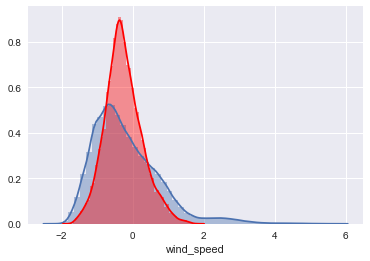

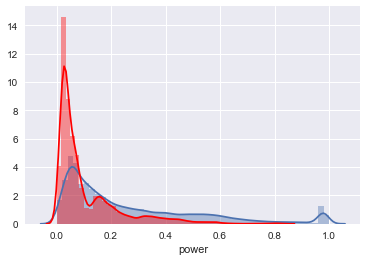

raw data:


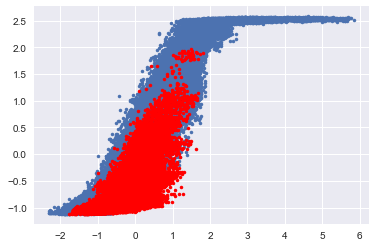

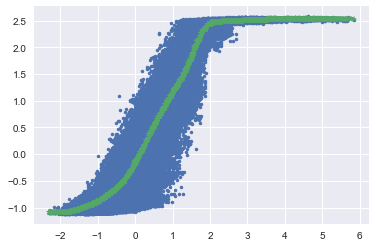

scaled data:


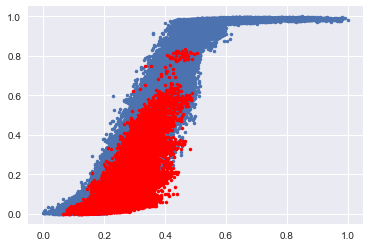

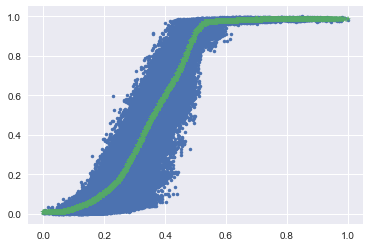

M21
data_raw: 正常:168930 (0.89 percent), 結冰:10638 (0.06 percent), Total:190494 

data_scaled: 正常:168930 (0.89 percent), 結冰:10638 (0.06 percent), Total:190494 

raw data:
            power  wind_speed
count  190494.000  190494.000
mean        0.401       0.392
std         1.055       1.045
min        -1.118      -1.854
25%        -0.457      -0.286
50%         0.209       0.282
75%         1.101       0.883
max         2.624       5.791
scaled data:
            power  wind_speed
count  190494.000  190494.000
mean        0.406       0.294
std         0.282       0.137
min         0.000       0.000
25%         0.177       0.205
50%         0.355       0.279
75%         0.593       0.358
max         1.000       1.000
Distribution:


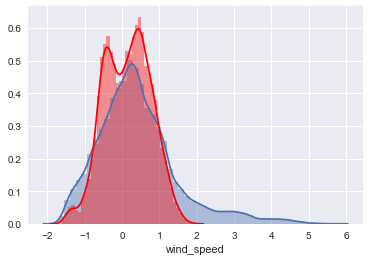

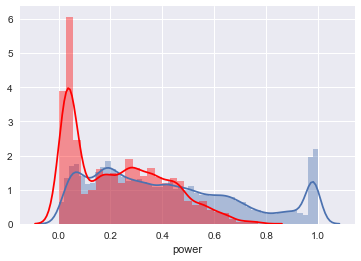

raw data:


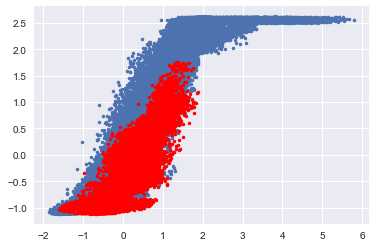

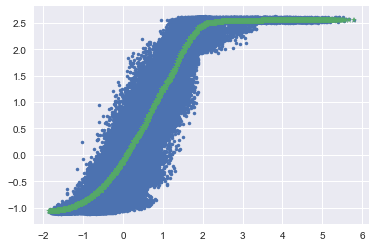

scaled data:


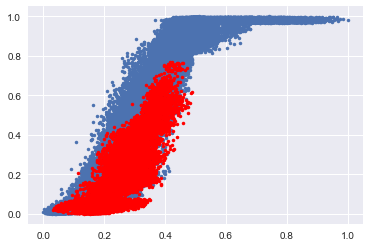

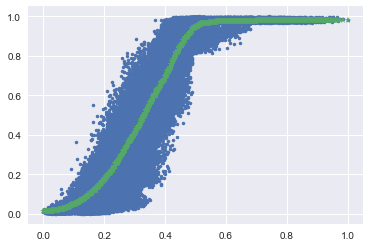

M08
data_raw:  

data_scaled:  

raw data:
            power  wind_speed
count  202328.000  202328.000
mean        0.385       0.287
std         1.014       1.006
min        -1.120      -1.931
25%        -0.429      -0.342
50%         0.217       0.204
75%         1.053       0.772
max         2.606       5.330
scaled data:
            power  wind_speed
count  202328.000  202328.000
mean        0.404       0.306
std         0.272       0.139
min         0.000       0.000
25%         0.185       0.219
50%         0.359       0.294
75%         0.583       0.372
max         1.000       1.000
Distribution:


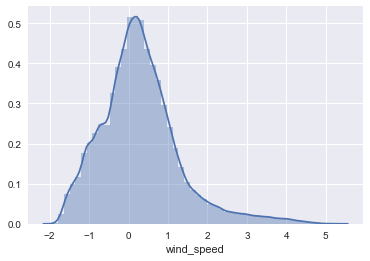

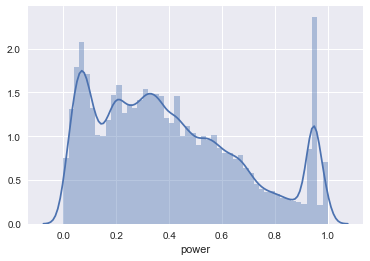

raw data:


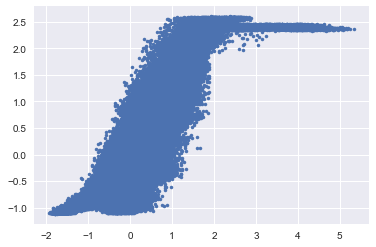

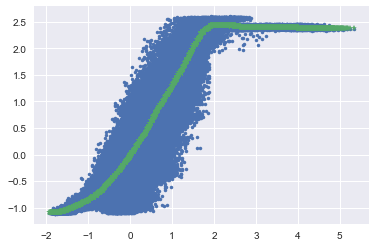

scaled data:


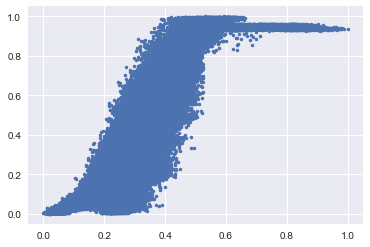

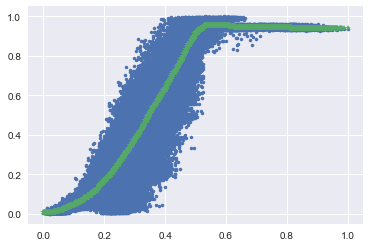

In [151]:
print('M15')
powercurve_analysis(data_raw_M15,dat_scaled_M15)
HTML('''<HR>''')
print('M21')
powercurve_analysis(data_raw_M21,dat_scaled_M21)
HTML('''<HR>''')
print('M08')
powercurve_analysis(data_raw_M8,dat_scaled_M8)

In [79]:
M15_op_cutin=(-1.5,0.1)
M15_op_cutout=(1.9,0.45)
M21_op_cutin=(-1.5,0.1)
M21_op_cutout=(1.9,0.45)
M08_op_cutin=(-1.5, 0.1)
M08_op_cutout=(1.9, 0.5)

*** Pass Data Only ***

In [92]:
data_raw_M15_pass = data_raw_M15[data_raw_M15['label']==0]
data_raw_M21_pass = data_raw_M21[data_raw_M21['label']==0]
dat_scaled_M15_pass = dat_scaled_M15[dat_scaled_M15['label']==0]
dat_scaled_M21_pass = dat_scaled_M21[dat_scaled_M21['label']==0]

M15
正常:350255 (1.00 percent), 結冰:0 (0.00 percent), Total:350255 

raw data:
            power  wind_speed
count  350255.000  350255.000
mean       -0.140      -0.186
std         0.921       0.945
min        -1.120      -2.293
25%        -0.847      -0.858
50%        -0.495      -0.368
75%         0.335       0.322
max         2.580       5.836
scaled data:
            power  wind_speed
count  350255.000  350255.000
mean        0.265       0.259
std         0.249       0.116
min         0.000       0.000
25%         0.074       0.176
50%         0.169       0.237
75%         0.393       0.322
max         1.000       1.000
Distribution:


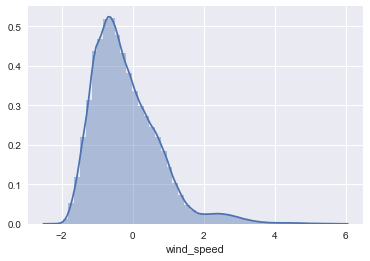

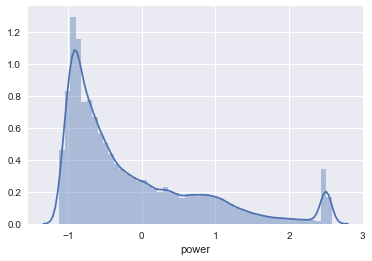

raw data:


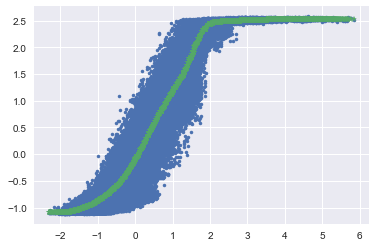

scaled data:


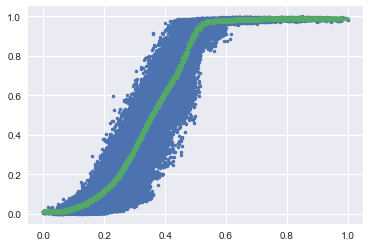

M21
正常:168930 (1.00 percent), 結冰:0 (0.00 percent), Total:168930 

raw data:
            power  wind_speed
count  168930.000  168930.000
mean        0.442       0.406
std         1.066       1.079
min        -1.116      -1.854
25%        -0.433      -0.294
50%         0.243       0.278
75%         1.169       0.901
max         2.624       5.791
scaled data:
            power  wind_speed
count  168930.000  168930.000
mean        0.417       0.296
std         0.285       0.141
min         0.001       0.000
25%         0.183       0.204
50%         0.364       0.279
75%         0.611       0.360
max         1.000       1.000
Distribution:


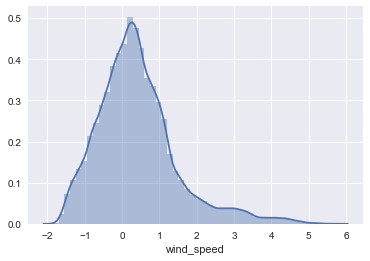

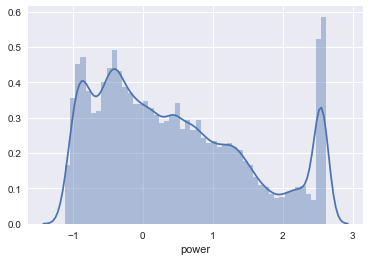

raw data:


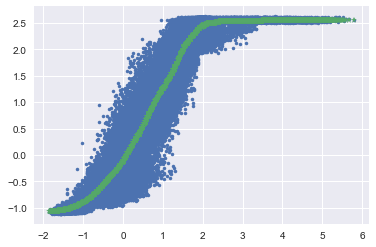

scaled data:


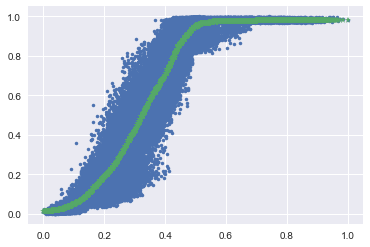

In [93]:
print('M15')
powercurve_analysis(data_raw_M15_pass,dat_scaled_M15_pass)
HTML('''<HR>''')
print('M21')
powercurve_analysis(data_raw_M21_pass,dat_scaled_M21_pass)


In [ ]:
M15_op_cutin=(-1.5,0.1)
M15_op_cutout=(1.9,0.45)
M21_op_cutin=(-1.5,0.1)
M21_op_cutout=(1.9,0.45)


In [161]:
a = HTML('''<tr>
<td> TEST</td>
<td> <img src="Nordic_trails.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr>''')


In [160]:
a

TEST,
